# Load data

In [60]:
library(pheatmap)
library(metacell)
library(tgconfig)
library(ggplot2)
library(cowplot)
library(circlize)
library(ggpubr)
library(reshape2)
source('/Volumes/Nexus/Projects/Repos/scTools/scTools_meta.R')
source('/Volumes/Nexus/Projects/Repos/scTools/scTools_plot.R')
setwd('/Volumes/Nexus/Projects/Project_PsA/')


In [61]:
##########
set_param("scm_spike_regexp","^ERCC-","metacell")
set_param("scm_mc_mark_k_per_clust",100,"metacell") #default: 5
set_param("scm_mc_mark_min_gene_cov",0.3,"metacell") # default: 0.25
set_param("scm_mc_mark_min_gene_fold",2,"metacell") # default: 1.5

set_param("mcell_mc2d_K",30,"metacell") # default: 20
set_param("mcell_mc2d_T_edge",0.02,"metacell") # default: 0.05
set_param("mcell_mc2d_max_confu_deg",4,"metacell") # default: 5
set_param("mcell_mc2d_edge_asym",FALSE,"metacell") # default: TRUE
set_param("mcell_mc2d_proj_blur",0.02,"metacell") # default: 0.02

set_param("mcp_heatmap_height", 6000, "metacell")
set_param("mcp_heatmap_width", 3000, "metacell")
set_param("mcp_heatmap_text_cex", 1, "metacell")

pjname <- 'PsA_v8_Blood'
dbpath <- 'data_PsA_v8_Blood'
fgpath <- 'figs_PsA_v8_Blood'
mat_id <- 'PsA_v8_Blood'
mtpath <- 'meta_SPID_PSA_v8_Blood.txt'

In [62]:
scdb_init(dbpath, force_reinit=T)
mat <- scdb_mat(mat_id)
scfigs_init(fgpath)

gset <- scdb_gset("test_feats")
gstat <- scdb_gstat("test")
mc<-scdb_mc("test_mc")
pct<-cal_mc_pct(mat,mc)
mc2d <- scdb_mc2d("test_mc_2dproj")

initializing scdb to data_PsA_v8_Blood



In [63]:
anpath <- file.path(fgpath, paste0(pjname, "_ann.txt"))
if(!file.exists(anpath)){
  ann <- data.frame(mcID = seq(1, max(mc@mc)), Populations = 'UN')
  write.table(ann, anpath, sep="\t", quote = F, row.names = F)
}else{
  ann <- read.table(anpath, header=T)
}

# Initialize settings

In [64]:
table(ann$Populations)


              B            cDC1            cDC2        Doublets           KRT19 
              8              30              93               1               1 
            mDC              Mf              Mo        Mo_Blood         Mo_CD16 
             19              86             184              12               1 
             NK             pDC               T      T_Effector T_Effector_GNLY 
             10               3              26              12               5 
        T_Naive            Treg 
             28               2 

In [65]:
##########
excl <- c(333, 334)
# excl <- c()
pop <- sort(unique(ann$Populations))

col_pop_Imm <- c('chartreuse4', 'aquamarine', 'darkorange', 'purple', 'burlywood', 'darkgreen', 'deepskyblue4', 
                 'firebrick1', 'chocolate4', 'mediumseagreen', 'magenta', 
                 'darkturquoise', 'lightsalmon', 'darkred', 'deeppink', "darkblue",
                 'grey11', 'grey55', 'grey99')
order_pop_Imm <- c("Mo_Blood", "Mo_CD16", "Mo", "Mf", "mDC", "cDC1", "cDC2", 
                   "NK", "pDC", "B", "Plasma", 
                   "T", "T_Effector_GNLY", "T_Effector", "Treg", "T_Naive",
                   "Doublets", "KRT19", "UN")
names(col_pop_Imm) <- order_pop_Imm
col_pop_Imm

setdiff(pop, order_pop_Imm)
pop <- setdiff(pop, c('UN', 'Doublets', 'KRT19'))

Mo_Blood          Mo_CD16               Mo               Mf 
   "chartreuse4"     "aquamarine"     "darkorange"         "purple" 
             mDC             cDC1             cDC2               NK 
     "burlywood"      "darkgreen"   "deepskyblue4"     "firebrick1" 
             pDC                B           Plasma                T 
    "chocolate4" "mediumseagreen"        "magenta"  "darkturquoise" 
 T_Effector_GNLY       T_Effector             Treg          T_Naive 
   "lightsalmon"        "darkred"       "deeppink"       "darkblue" 
        Doublets            KRT19               UN 
        "grey11"         "grey55"         "grey99"

character(0)

In [66]:
meta <- read.table(mtpath, header=T, row.names = 1, sep="\t")
meta <- meta[intersect(rownames(meta), rownames(mc@n_bc)),]
head(meta)
table(meta$Diagnosis)

,Seq.Batch.ID,Batch.Set.ID,Patient_Name,Diagnosis,Gating,Tissue,Sample,PID,Note
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AB5418,SB172,PsA_SFYC_CD45+_Frozen12RTP,YC,PsA,CD45,SF,Frozen,PsA_001,-
AB5419,SB172,PsA_SFYC_CD45+_Frozen12RTP,YC,PsA,CD45,SF,Frozen,PsA_001,-
AB5420,SB172,PsA_SFYC_CD45+_Frozen12RTP,YC,PsA,CD45,SF,Frozen,PsA_001,-
AB5458,SB173,OA_pt01_cd45_SF,OA_1,OA,CD45,SF,Frozen,OA_001,-
AB5459,SB173,OA_pt01_cd45_SF,OA_1,OA,CD45,SF,Frozen,OA_001,-
AB5460,SB173,OA_pt01_cd45_SF,OA_1,OA,CD45,SF,Frozen,OA_001,-



Control      OA     PsA 
     44      39     459 

In [67]:
# library(NMF)
library(ComplexHeatmap)

In [68]:
########## make cells_Imm
pop_all <- sort(unique(as.vector(ann$Populations)))
pop_all <- setdiff(pop_all, 'UN')
mc_Imm <- melt(mc@mc[!(mc@mc %in% excl)])
colnames(mc_Imm) <- c("mcID")
mc_Imm$cID <- rownames(mc_Imm)
head(mc_Imm)
dim(mc_Imm)

cell_meta <- mat@cell_metadata[,c("amp_batch_id", "seq_batch_id")]
cell_meta$cID <- rownames(cell_meta)
head(cell_meta)
dim(cell_meta)

cell_meta <- cell_meta[rownames(cell_meta) %in% rownames(mc_Imm),]
dim(cell_meta)

cells_Imm <- merge(mc_Imm, cell_meta)
head(cells_Imm)

dim(ann)
mc_ann <- ann[ann$mcID %in% unique(mc_Imm$mcID),]
dim(mc_ann)

cells_Imm <- merge(cells_Imm, mc_ann)
cells_Imm$pop <- cells_Imm$Populations
rownames(cells_Imm) <- cells_Imm$cID
head(cells_Imm)

head(meta)
meta$amp_batch_id <- rownames(meta)
cells_Imm <- merge(cells_Imm, meta)
cells_Imm$batch_set_id <- cells_Imm$Batch.Set.ID
rownames(cells_Imm) <- cells_Imm$cID
head(cells_Imm)
dim(cells_Imm)

,mcID,cID
,<int>,<chr>
W2105817,235,W2105817
W2105818,33,W2105818
W2105819,128,W2105819
W2105820,38,W2105820
W2105821,30,W2105821
W2105823,175,W2105823


[1] 121561      2

,amp_batch_id,seq_batch_id,cID
,<chr>,<chr>,<chr>
W2105817,AB5418,SB172,W2105817
W2105818,AB5418,SB172,W2105818
W2105819,AB5418,SB172,W2105819
W2105820,AB5418,SB172,W2105820
W2105821,AB5418,SB172,W2105821
W2105822,AB5418,SB172,W2105822


[1] 208128      3

[1] 121561      3

,cID,mcID,amp_batch_id,seq_batch_id
,<chr>,<int>,<chr>,<chr>
1,W2105817,235,AB5418,SB172
2,W2105818,33,AB5418,SB172
3,W2105819,128,AB5418,SB172
4,W2105820,38,AB5418,SB172
5,W2105821,30,AB5418,SB172
6,W2105823,175,AB5418,SB172


[1] 521   2

[1] 519   2

,mcID,cID,amp_batch_id,seq_batch_id,Populations,pop
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
W2125722,1,W2125722,AB5469,SB173,Mo,Mo
W2672175,1,W2672175,AB6896,SB183,Mo,Mo
W2532134,1,W2532134,AB6532,SB180,Mo,Mo
W2570008,1,W2570008,AB6630,SB181,Mo,Mo
W2570001,1,W2570001,AB6630,SB181,Mo,Mo
W2534271,1,W2534271,AB6537,SB180,Mo,Mo


,Seq.Batch.ID,Batch.Set.ID,Patient_Name,Diagnosis,Gating,Tissue,Sample,PID,Note
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AB5418,SB172,PsA_SFYC_CD45+_Frozen12RTP,YC,PsA,CD45,SF,Frozen,PsA_001,-
AB5419,SB172,PsA_SFYC_CD45+_Frozen12RTP,YC,PsA,CD45,SF,Frozen,PsA_001,-
AB5420,SB172,PsA_SFYC_CD45+_Frozen12RTP,YC,PsA,CD45,SF,Frozen,PsA_001,-
AB5458,SB173,OA_pt01_cd45_SF,OA_1,OA,CD45,SF,Frozen,OA_001,-
AB5459,SB173,OA_pt01_cd45_SF,OA_1,OA,CD45,SF,Frozen,OA_001,-
AB5460,SB173,OA_pt01_cd45_SF,OA_1,OA,CD45,SF,Frozen,OA_001,-


,amp_batch_id,mcID,cID,seq_batch_id,Populations,pop,Seq.Batch.ID,Batch.Set.ID,Patient_Name,Diagnosis,Gating,Tissue,Sample,PID,Note,batch_set_id
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
W3876428,AB10032,57,W3876428,SB202,Mo_Blood,Mo_Blood,SB202,Biomek_A1_FMF blood Healthy Tali CD45_2,Blood_Tali,Control,CD45,Blood,-,Control_Tali,-,Biomek_A1_FMF blood Healthy Tali CD45_2
W3876424,AB10032,255,W3876424,SB202,NK,NK,SB202,Biomek_A1_FMF blood Healthy Tali CD45_2,Blood_Tali,Control,CD45,Blood,-,Control_Tali,-,Biomek_A1_FMF blood Healthy Tali CD45_2
W3876096,AB10032,48,W3876096,SB202,Mo,Mo,SB202,Biomek_A1_FMF blood Healthy Tali CD45_2,Blood_Tali,Control,CD45,Blood,-,Control_Tali,-,Biomek_A1_FMF blood Healthy Tali CD45_2
W3876171,AB10032,312,W3876171,SB202,T_Effector_GNLY,T_Effector_GNLY,SB202,Biomek_A1_FMF blood Healthy Tali CD45_2,Blood_Tali,Control,CD45,Blood,-,Control_Tali,-,Biomek_A1_FMF blood Healthy Tali CD45_2
W3876291,AB10032,256,W3876291,SB202,NK,NK,SB202,Biomek_A1_FMF blood Healthy Tali CD45_2,Blood_Tali,Control,CD45,Blood,-,Control_Tali,-,Biomek_A1_FMF blood Healthy Tali CD45_2
W3876109,AB10032,318,W3876109,SB202,T_Effector_GNLY,T_Effector_GNLY,SB202,Biomek_A1_FMF blood Healthy Tali CD45_2,Blood_Tali,Control,CD45,Blood,-,Control_Tali,-,Biomek_A1_FMF blood Healthy Tali CD45_2


[1] 121561     16

In [69]:
table(cells_Imm$Diagnosis)
table(paste(cells_Imm$Diagnosis, cells_Imm$PID))


Control      OA     PsA 
   5496    9039  107026 


      Control Control_GA      Control Control_Jiq    Control Control_Keren 
                     223                      360                      453 
    Control Control_Kfir   Control Control_Kfir_1   Control Control_Kfir_2 
                     328                      776                      226 
  Control Control_Kfir_3   Control Control_Kfir_4   Control Control_Kfir_5 
                     379                      453                       98 
    Control Control_Meit   Control Control_Natali Control Control_Paolin_3 
                     192                      525                      497 
     Control Control_Pas       Control Control_Sa     Control Control_Tali 
                     139                      161                      474 
     Control Control_Yon                OA OA_001                OA OA_002 
                     212                     1270                      836 
               OA OA_003                OA OA_004                OA OA_005 
           

In [70]:
gpop <- c('cDC2')
type_Now <- cells_Imm[cells_Imm$pop %in% gpop,]
type_Now <- cells_Imm[cells_Imm$pop %in% gpop & cells_Imm$Tissue %in% c('SF', 'Blood'),]

In [78]:
type_Now$Final.ID <- paste(type_Now$Diagnosis, type_Now$PID, sep = '|')
type_Now$Final.ID <- type_Now$PID
gpop_ind_cnt <- table(type_Now$Final.ID)
gpop_ind_cnt
gpop_ind_cnt_good <- names(gpop_ind_cnt[gpop_ind_cnt > 35])
gpop_ind_cnt_good
gpop_ind_cnt_good <- setdiff(gpop_ind_cnt_good, c("OA_010"))
gpop_ind_cnt_good <- grep('^Control', gpop_ind_cnt_good, v = T, invert = T)
gpop_ind_cnt_good


      Control_GA      Control_Jiq    Control_Keren     Control_Kfir 
              13               17                9               19 
  Control_Kfir_1   Control_Kfir_2   Control_Kfir_3   Control_Kfir_4 
              37                6                9               13 
  Control_Kfir_5     Control_Meit   Control_Natali Control_Paolin_3 
               2                8               17               23 
     Control_Pas       Control_Sa     Control_Tali      Control_Yon 
               9                7                8               13 
          OA_001           OA_002           OA_003           OA_004 
             215              108              342              110 
          OA_005           OA_006           OA_007           OA_008 
              24              315              265              491 
          OA_009          PsA_001          PsA_002          PsA_003 
             253               36              494              989 
       PsA_003.1          PsA_004

[1] "Control_Kfir_1" "OA_001"         "OA_002"         "OA_003"        
 [5] "OA_004"         "OA_006"         "OA_007"         "OA_008"        
 [9] "OA_009"         "PsA_001"        "PsA_002"        "PsA_003"       
[13] "PsA_003.1"      "PsA_004"        "PsA_006"        "PsA_006.1"     
[17] "PsA_007"        "PsA_008"        "PsA_008.1"      "PsA_009"       
[21] "PsA_010"        "PsA_012"        "PsA_012.1"      "PsA_013"       
[25] "PsA_014"        "PsA_015"        "PsA_018"        "PsA_020"       
[29] "PsA_021"        "PsA_022"        "PsA_022.1"      "PsA_023"       
[33] "PsA_024"        "PsA_025"        "PsA_026"        "PsA_027"       
[37] "PsA_028"        "PsA_029"        "PsA_030"        "PsA_031"       
[41] "PsA_033.1"      "PsA_033.2"      "PsA_034"        "PsA_035"       
[45] "PsA_036"        "PsA_037"        "PsA_039"        "PsA_040"       
[49] "PsA_041"        "PsA_043"        "PsA_044"        "PsA_045"       
[53] "PsA_046"        "PsA_047"        "PsA_048"

[1] "OA_001"    "OA_002"    "OA_003"    "OA_004"    "OA_006"    "OA_007"   
 [7] "OA_008"    "OA_009"    "PsA_001"   "PsA_002"   "PsA_003"   "PsA_003.1"
[13] "PsA_004"   "PsA_006"   "PsA_006.1" "PsA_007"   "PsA_008"   "PsA_008.1"
[19] "PsA_009"   "PsA_010"   "PsA_012"   "PsA_012.1" "PsA_013"   "PsA_014"  
[25] "PsA_015"   "PsA_018"   "PsA_020"   "PsA_021"   "PsA_022"   "PsA_022.1"
[31] "PsA_023"   "PsA_024"   "PsA_025"   "PsA_026"   "PsA_027"   "PsA_028"  
[37] "PsA_029"   "PsA_030"   "PsA_031"   "PsA_033.1" "PsA_033.2" "PsA_034"  
[43] "PsA_035"   "PsA_036"   "PsA_037"   "PsA_039"   "PsA_040"   "PsA_041"  
[49] "PsA_043"   "PsA_044"   "PsA_045"   "PsA_046"   "PsA_047"   "PsA_048"

In [79]:
n <- 35
cells_Now <- type_Now[type_Now$Final.ID %in% gpop_ind_cnt_good,]

mc_Now <- structure(as.vector(cells_Now$Final.ID), names = rownames(cells_Now))
length(mc_Now)
mat_Now <- mat@mat[,rownames(cells_Now)]
dim(mat_Now)


[1] 21870

[1] 56176 21870

In [14]:
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,5144800,274.8,8442500,450.9,NA,8442500,450.9
Vcells,295625083,2255.5,450928416,3440.4,65536,375706998,2866.5


In [80]:
source('/Volumes/Nexus/Projects/Repos/scTools/MetacellWay_lib.R')
gpop_fp <- cl_compute_fp(mc_Now, mat_Now)
gpop_egc <- cl_compute_e_gc(mc_Now, mat_Now)
head(gpop_fp)

,OA_001,OA_002,OA_003,OA_004,OA_006,OA_007,OA_008,OA_009,PsA_001,PsA_002,⋯,PsA_037,PsA_039,PsA_040,PsA_041,PsA_043,PsA_044,PsA_045,PsA_046,PsA_047,PsA_048
5S_rRNA,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.000000,1.0000000,1.0000000,1.0000000,⋯,1.0000000,1.0078583,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000
7SK,1.0126420,1.0000000,1.0000000,1.0000000,1.0000000,1.0181054,1.000000,1.0194529,1.0000000,1.0000000,⋯,1.0000000,1.0078583,1.0000000,1.0000000,1.0000000,1.0145849,1.0000000,1.0000000,1.0000000,1.0000000
A1BG,0.9305970,0.9899259,1.1151063,1.3421899,0.9217219,1.0492108,1.031041,1.1414209,0.9992352,0.9153458,⋯,0.9920153,1.1075925,0.9942143,1.0068086,1.1057336,0.9071947,1.0589404,0.9483019,0.9598042,0.9327057
A1BG-AS1,1.0089501,0.9914833,1.0065634,0.9746491,1.0749329,0.9969285,1.036342,1.0428605,0.9746491,0.9746491,⋯,0.9950033,1.0098584,0.9904456,1.0247832,0.9983598,0.9746491,0.9958465,0.9746491,1.0898256,0.9746491
A2M,1.1113355,0.6502343,0.7540234,1.0489366,1.0780888,1.1410508,1.149990,1.2585512,0.6402372,0.8324384,⋯,1.1540765,0.6016361,1.0432507,1.0262896,1.1190437,0.8035524,0.9920706,0.9131196,1.0767860,1.3312322
A2M-AS1,0.9881255,0.9881255,1.0099556,0.9881255,0.9881255,0.9881255,1.000188,0.9881255,1.0502959,1.0219512,⋯,0.9960954,1.0036669,0.9881255,0.9881255,1.0362856,1.0025373,1.0024426,1.0132146,1.0022933,0.9881255


In [81]:
gpop_fp_log2 <- log2(gpop_fp)
gpop_fp_diff <- gpop_fp_log2[apply(gpop_fp_log2, 1, function(x) max(x) - min(x) > 2),]
sort(rownames(gpop_fp_diff))
black_term <- c("^AC[0-9]+\\.", "^AP[0-9]+\\.", "^AL[0-9]+\\.", "-AS[0-9]*$", "^MIR[0-9]", "^LINC[0-9]", "^SNOR", "^sno", "^SNR", '\\.')
black_gene <- foreach(i = black_term, .combine = c) %do% grep(i, rownames(gpop_fp_diff), v = T)
gpop_fp_diff <- gpop_fp_diff[setdiff(rownames(gpop_fp_diff), black_gene),]
white_gene <- c("PSMB9", "PSMB10", "PSMB8", "TAP1", "UBE2L6", "TAPBP", "PSME1")
white_gene <- c()
final_genes <- union(rownames(gpop_fp_diff), white_gene)
gpop_fp_diff <- gpop_fp_log2[final_genes,]
dim(gpop_fp_diff)

[1] "AC006970.1" "AC116347.1" "AC136475.8" "AC233964.1" "AL591846.1"
 [6] "AL928654.4" "ALOX5AP"    "B2M"        "C15orf48"   "CCL17"     
[11] "CD14"       "CD1C"       "CD1E"       "CD52"       "CST7"      
[16] "CYBA"       "DBI"        "EMP1"       "EMP3"       "EZR"       
[21] "FAM26F"     "FBP1"       "FCER1A"     "FOS"        "FPR1"      
[26] "FTH1"       "FTLP3"      "GBP1"       "HLA-A"      "HLA-B"     
[31] "HLA-DQA1"   "HLA-DQA2"   "HLA-DQB1"   "HLA-DQB2"   "HLA-DRB1"  
[36] "HLA-DRB5"   "HLA-DRB6"   "IFITM1"     "IFITM2"     "IFITM3"    
[41] "IL4I1"      "ISG15"      "LAP3"       "LGALS2"     "LMNA"      
[46] "LYZ"        "MIF"        "MIR147B"    "MIR3648-1"  "MMP12"     
[51] "MRC1"       "MT2A"       "NEAT1"      "PPA1"       "PSMB10"    
[56] "PSMB9"      "PSME1"      "PSME2"      "PSME2P2"    "RGS1"      
[61] "S100A10"    "S100A5"     "S100A9"     "S100B"      "STAT1"     
[66] "TYMP"       "VAMP5"      "VSIG4"      "WARS"

[1] 61 54

In [82]:
head(gpop_fp_diff)
Control <- c(colnames(gpop_fp_diff)[grep("^Control", colnames(gpop_fp_diff))])
OA <- c(colnames(gpop_fp_diff)[grep("^OA", colnames(gpop_fp_diff))])
PsA <- c(colnames(gpop_fp_diff)[grep("^PsA", colnames(gpop_fp_diff))])

Resp_All <- c(Control, OA, PsA)
Resp_All
gpop_fp_diff <- gpop_fp_diff[,Resp_All]

,OA_001,OA_002,OA_003,OA_004,OA_006,OA_007,OA_008,OA_009,PsA_001,PsA_002,⋯,PsA_037,PsA_039,PsA_040,PsA_041,PsA_043,PsA_044,PsA_045,PsA_046,PsA_047,PsA_048
ALOX5AP,0.08961383,-0.07792251,0.50816236,0.3720521,0.4031578,-0.05159648,0.77586521,0.8613007,-1.4061652,0.291586242,⋯,-0.366600671,-0.4244989,-0.39517979,-0.09350146,0.7214561,0.044599389,0.48189150,0.56870104,-0.1485756,-1.40864057
B2M,-0.24474954,-0.24426394,0.45358457,-1.0128080,-0.8721933,-0.98057225,-0.72696166,-0.2236443,0.3327087,0.157601473,⋯,-0.187304815,-0.6179059,0.15760919,0.05271126,-0.3762843,-0.005494445,0.11125813,0.71601762,0.7786124,0.60428844
C15orf48,-0.67456948,-0.53630553,-0.37167331,-0.3792243,-0.6867274,-0.64663287,-0.51056411,-0.4060808,1.3606859,-0.212648657,⋯,0.034355039,0.5634725,0.05476357,0.97632374,-0.6039840,-0.380039134,-0.38374778,-0.24238239,0.8790306,0.19728750
CCL17,-0.05265489,0.05598705,-0.02944449,-0.0641057,0.1233818,0.08187789,0.09716145,-0.0089667,-0.0641057,0.024065264,⋯,-0.064105702,1.8922813,0.01769183,-0.06410570,-0.0641057,-0.002227234,-0.05369882,0.01876496,0.1384404,-0.06410570
CD14,0.43242309,0.12899283,0.21338182,0.3380505,0.7133049,0.08862182,0.61220689,0.0903596,0.2666466,-0.003466677,⋯,0.003458367,-0.2113088,0.38121061,-0.16730212,1.8127874,0.750542184,0.47653255,0.33939170,-0.2126975,-0.21111411
CD1C,-0.14695218,-0.15654768,0.50012803,0.2708366,-0.2618434,-0.15902617,0.28191635,0.5894011,-0.8843625,0.237269214,⋯,-0.007223497,0.8452156,-0.73113380,-0.34281300,-0.5244030,0.002732694,0.55474179,-0.36963403,0.2600686,0.01903963


[1] "OA_001"    "OA_002"    "OA_003"    "OA_004"    "OA_006"    "OA_007"   
 [7] "OA_008"    "OA_009"    "PsA_001"   "PsA_002"   "PsA_003"   "PsA_003.1"
[13] "PsA_004"   "PsA_006"   "PsA_006.1" "PsA_007"   "PsA_008"   "PsA_008.1"
[19] "PsA_009"   "PsA_010"   "PsA_012"   "PsA_012.1" "PsA_013"   "PsA_014"  
[25] "PsA_015"   "PsA_018"   "PsA_020"   "PsA_021"   "PsA_022"   "PsA_022.1"
[31] "PsA_023"   "PsA_024"   "PsA_025"   "PsA_026"   "PsA_027"   "PsA_028"  
[37] "PsA_029"   "PsA_030"   "PsA_031"   "PsA_033.1" "PsA_033.2" "PsA_034"  
[43] "PsA_035"   "PsA_036"   "PsA_037"   "PsA_039"   "PsA_040"   "PsA_041"  
[49] "PsA_043"   "PsA_044"   "PsA_045"   "PsA_046"   "PsA_047"   "PsA_048"

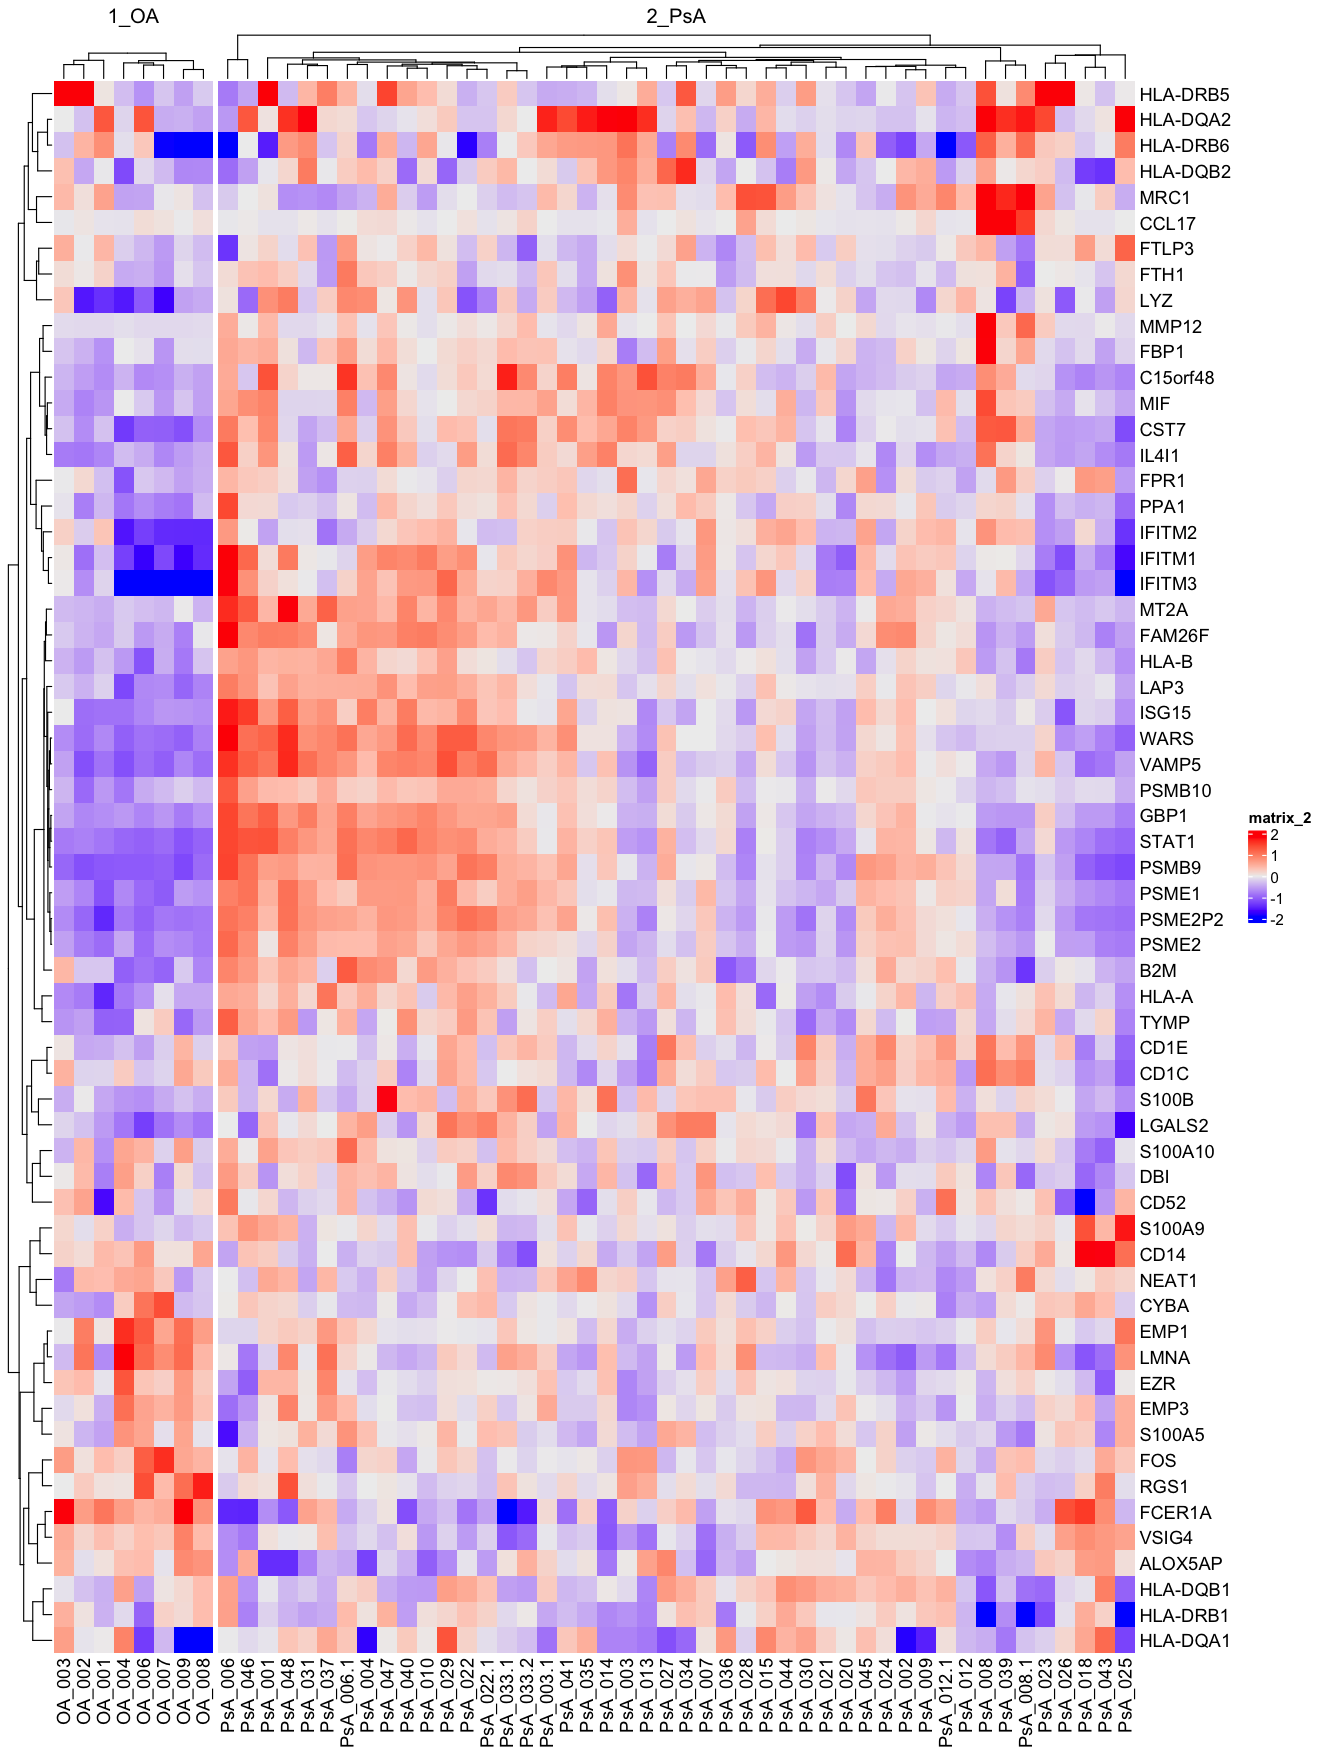

In [83]:
options(repr.plot.width = 12, repr.plot.height = 16, repr.plot.res = 110)

Heatmap(gpop_fp_diff, 
        column_split = rep(c("0_Control", "1_OA", "2_PsA"), 
                           c(length(Control), length(OA), length(PsA))),
        cluster_columns = T, 
        cluster_column_slices = F, 
        clustering_distance_row = 'spearman')

In [87]:
OA <- c('OA_001','OA_002','OA_003','OA_004','OA_006','OA_007','OA_008','OA_009')
Resp <- c("PsA_001", "PsA_003.1", "PsA_007", "PsA_014", "PsA_015", "PsA_020", "PsA_025", "PsA_026", "PsA_027", 
          "PsA_034", "PsA_035", "PsA_043", "PsA_045")
Part <- c("PsA_012", "PsA_023", "PsA_030", "PsA_031", "PsA_037")
NonR <- c("PsA_010", "PsA_009", "PsA_021", "PsA_022", "PsA_028", "PsA_029", "PsA_036", "PsA_039", "PsA_040", "PsA_041", "PsA_048")
Resi <- c("PsA_002", "PsA_004", "PsA_006", "PsA_008", "PsA_024", "PsA_033.1", "PsA_044", "PsA_046")

OA <- OA[OA %in% colnames(gpop_fp_diff)]
Resp <- Resp[Resp %in% colnames(gpop_fp_diff)]
Part <- Part[Part %in% colnames(gpop_fp_diff)]
NonR <- NonR[NonR %in% colnames(gpop_fp_diff)]
Resi <- Resi[Resi %in% colnames(gpop_fp_diff)]

Resp_All <- c(OA, Resp, Part, NonR, Resi)
Resp_All

[1] "OA_001"    "OA_002"    "OA_003"    "OA_004"    "OA_006"    "OA_007"   
 [7] "OA_008"    "OA_009"    "PsA_001"   "PsA_003.1" "PsA_007"   "PsA_014"  
[13] "PsA_015"   "PsA_020"   "PsA_025"   "PsA_026"   "PsA_027"   "PsA_034"  
[19] "PsA_035"   "PsA_043"   "PsA_045"   "PsA_012"   "PsA_023"   "PsA_030"  
[25] "PsA_031"   "PsA_037"   "PsA_010"   "PsA_009"   "PsA_021"   "PsA_022"  
[31] "PsA_028"   "PsA_029"   "PsA_036"   "PsA_039"   "PsA_040"   "PsA_041"  
[37] "PsA_048"   "PsA_002"   "PsA_004"   "PsA_006"   "PsA_008"   "PsA_024"  
[43] "PsA_033.1" "PsA_044"   "PsA_046"

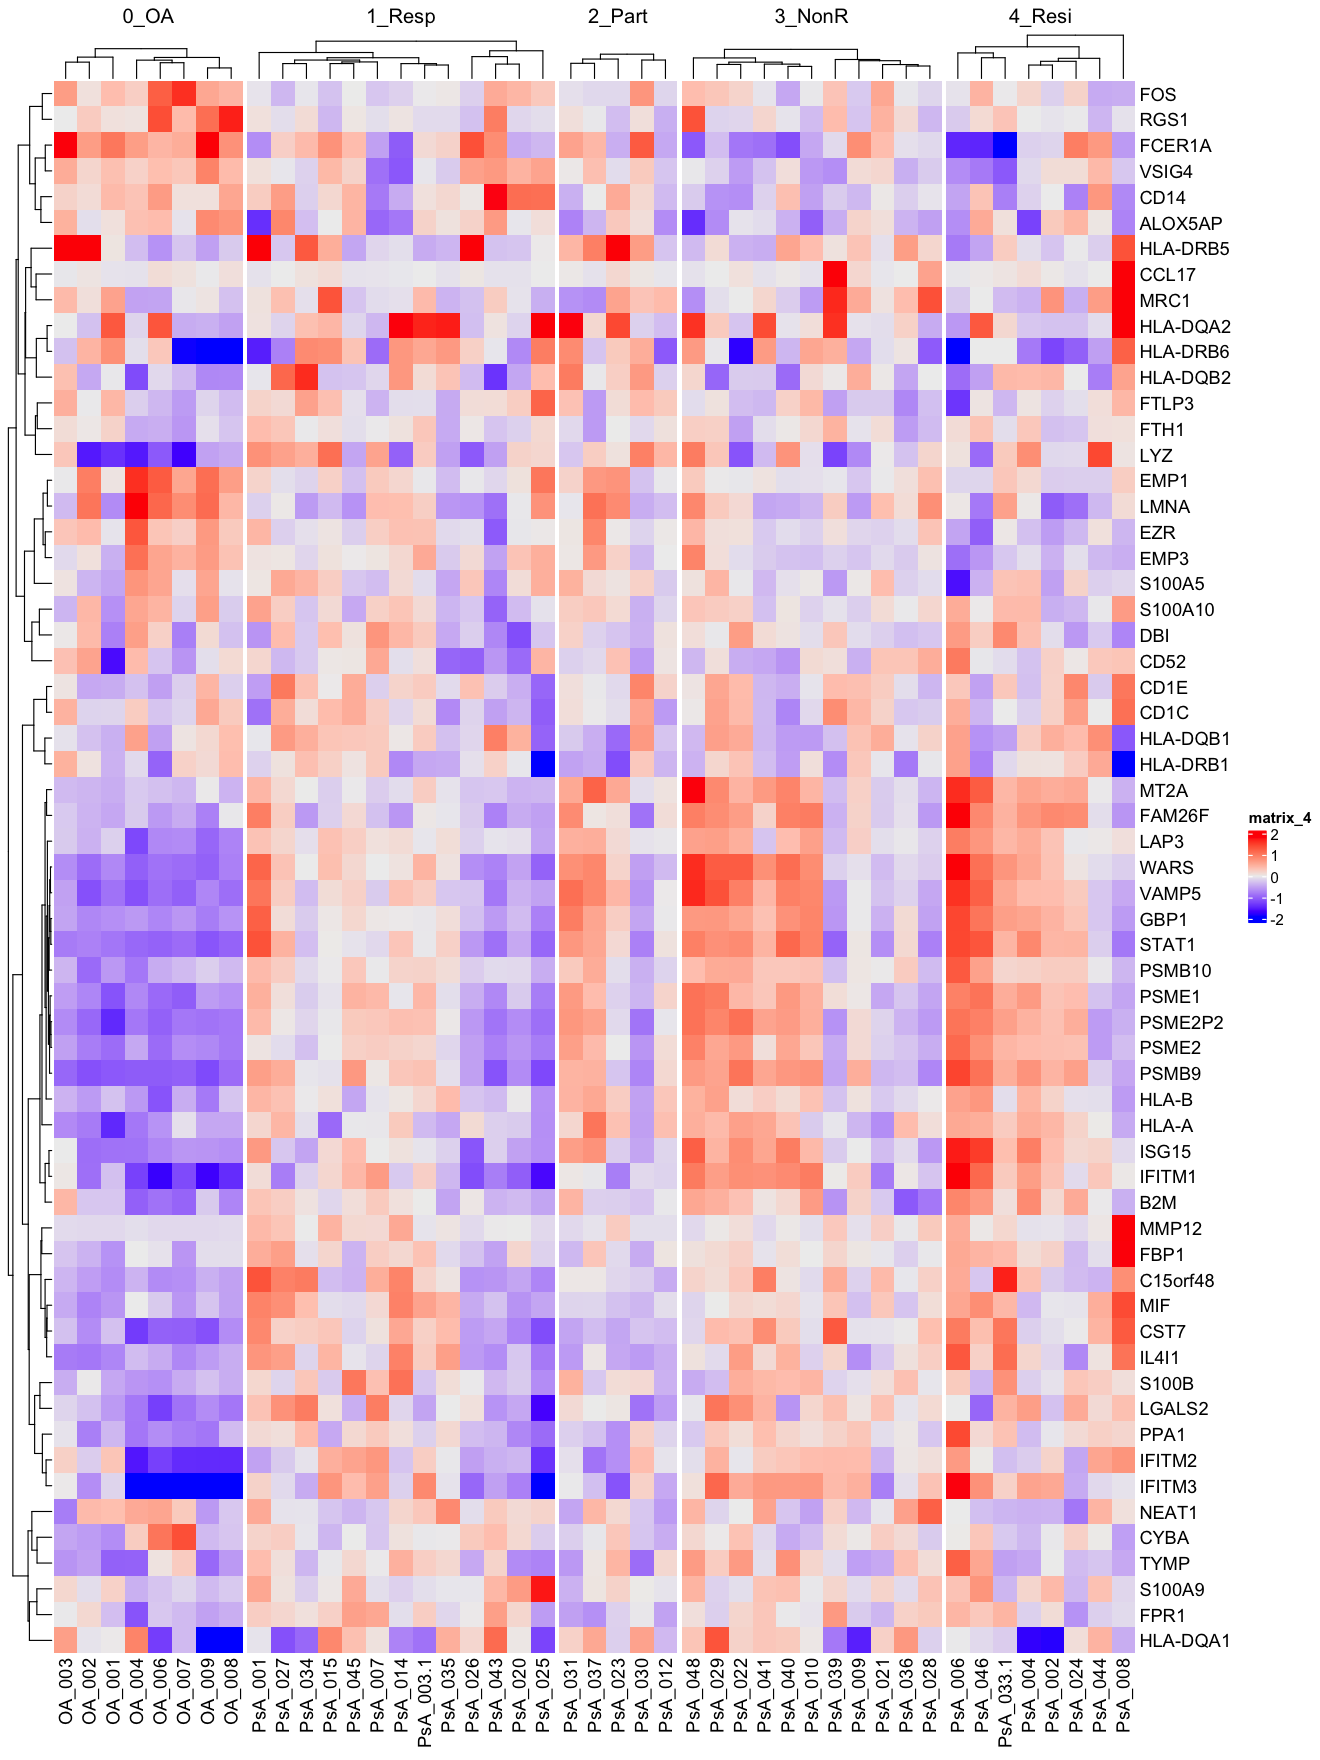

In [88]:
options(repr.plot.width = 12, repr.plot.height = 16, repr.plot.res = 110)

Heatmap(gpop_fp_diff[,Resp_All], #bottom_annotation = ha,
        cluster_columns = T, 
        cluster_column_slices = F, 
        clustering_distance_row = 'spearman',
        column_split = rep(c("0_OA", "1_Resp", "2_Part", "3_NonR", "4_Resi"), 
                           c(length(OA), length(Resp), length(Part), length(NonR), length(Resi))))

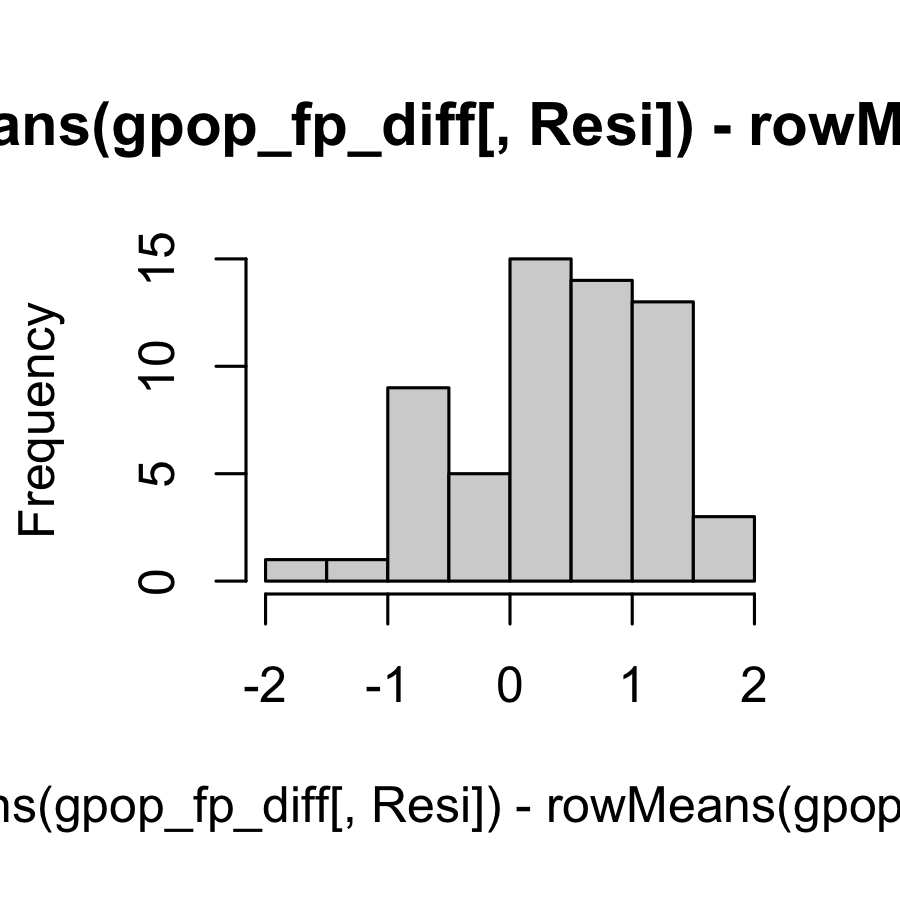

In [89]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 300)

hist(rowMeans(gpop_fp_diff[,Resi]) - rowMeans(gpop_fp_diff[,OA]))

In [90]:
genes_clean <- rownames(gpop_fp_diff)[rowMeans(gpop_fp_diff[,Resi]) - rowMeans(gpop_fp_diff[,OA]) > 1]
genes_clean

[1] "CST7"    "FAM26F"  "GBP1"    "IFITM1"  "IFITM2"  "IFITM3"  "ISG15"  
 [8] "LAP3"    "LYZ"     "PSMB9"   "PSME1"   "PSME2"   "PSME2P2" "STAT1"  
[15] "VAMP5"   "WARS"

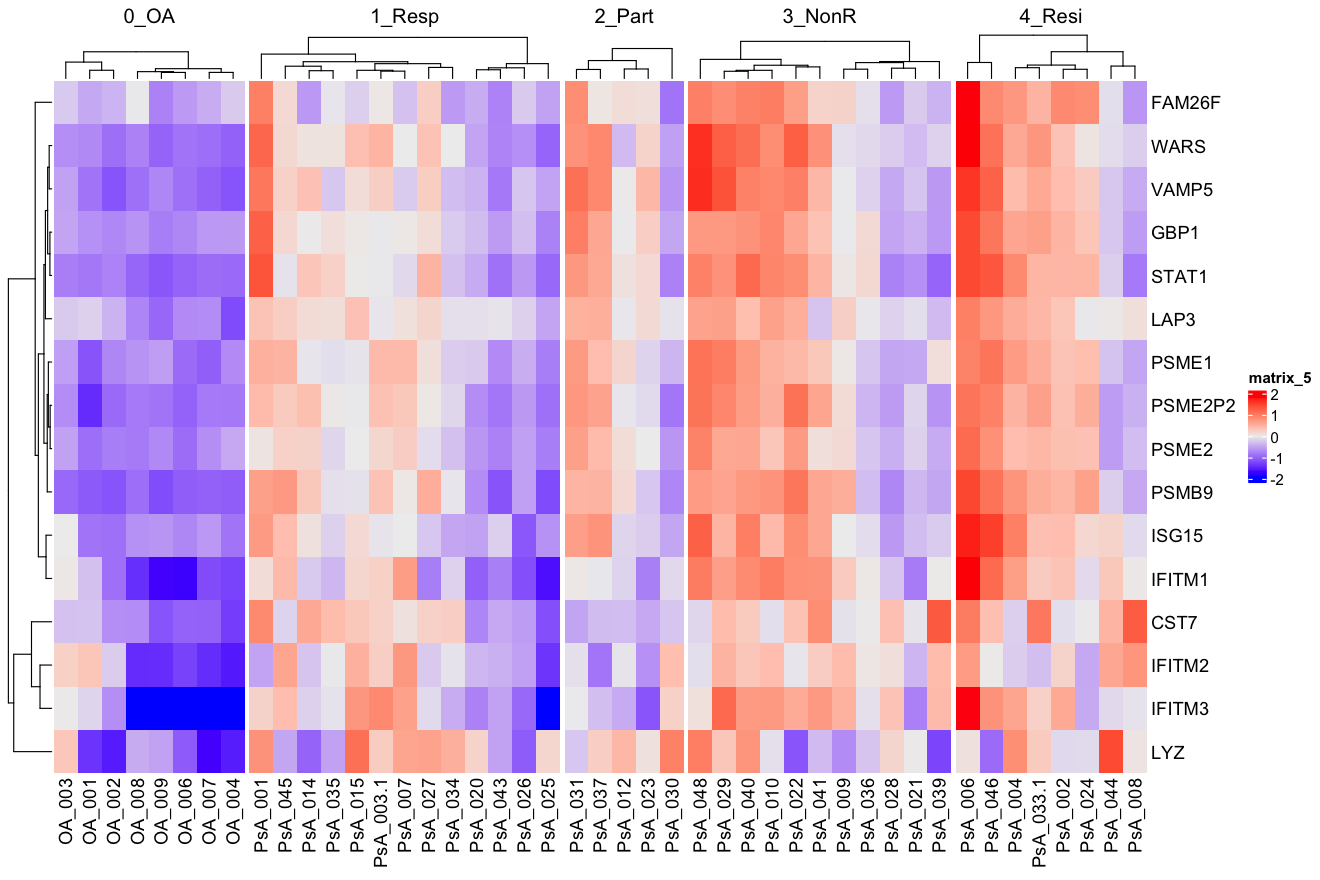

In [91]:
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 110)

gpop_fp_diff_clean <- gpop_fp_diff[genes_clean, Resp_All]
Heatmap(gpop_fp_diff_clean, #bottom_annotation = ha,
        cluster_columns = T, 
        cluster_column_slices = F, 
        clustering_distance_row = 'spearman',
        column_split = rep(c("0_OA", "1_Resp", "2_Part", "3_NonR", "4_Resi"), 
                           c(length(OA), length(Resp), length(Part), length(NonR), length(Resi))))

In [95]:
df <- melt(gpop_egc['POMP', Resp_All])
df$Grp <- rep(c("0_OA", "1_Resp", "2_Part", "3_NonR", "4_Resi"), 
                           c(length(OA), length(Resp), length(Part), length(NonR), length(Resi)))
head(df)

,value,Grp
,<dbl>,<chr>
OA_001,0.0001985982,0_OA
OA_002,0.0002251408,0_OA
OA_003,0.0002698683,0_OA
OA_004,0.0002052466,0_OA
OA_006,0.0002812262,0_OA
OA_007,0.0002020012,0_OA


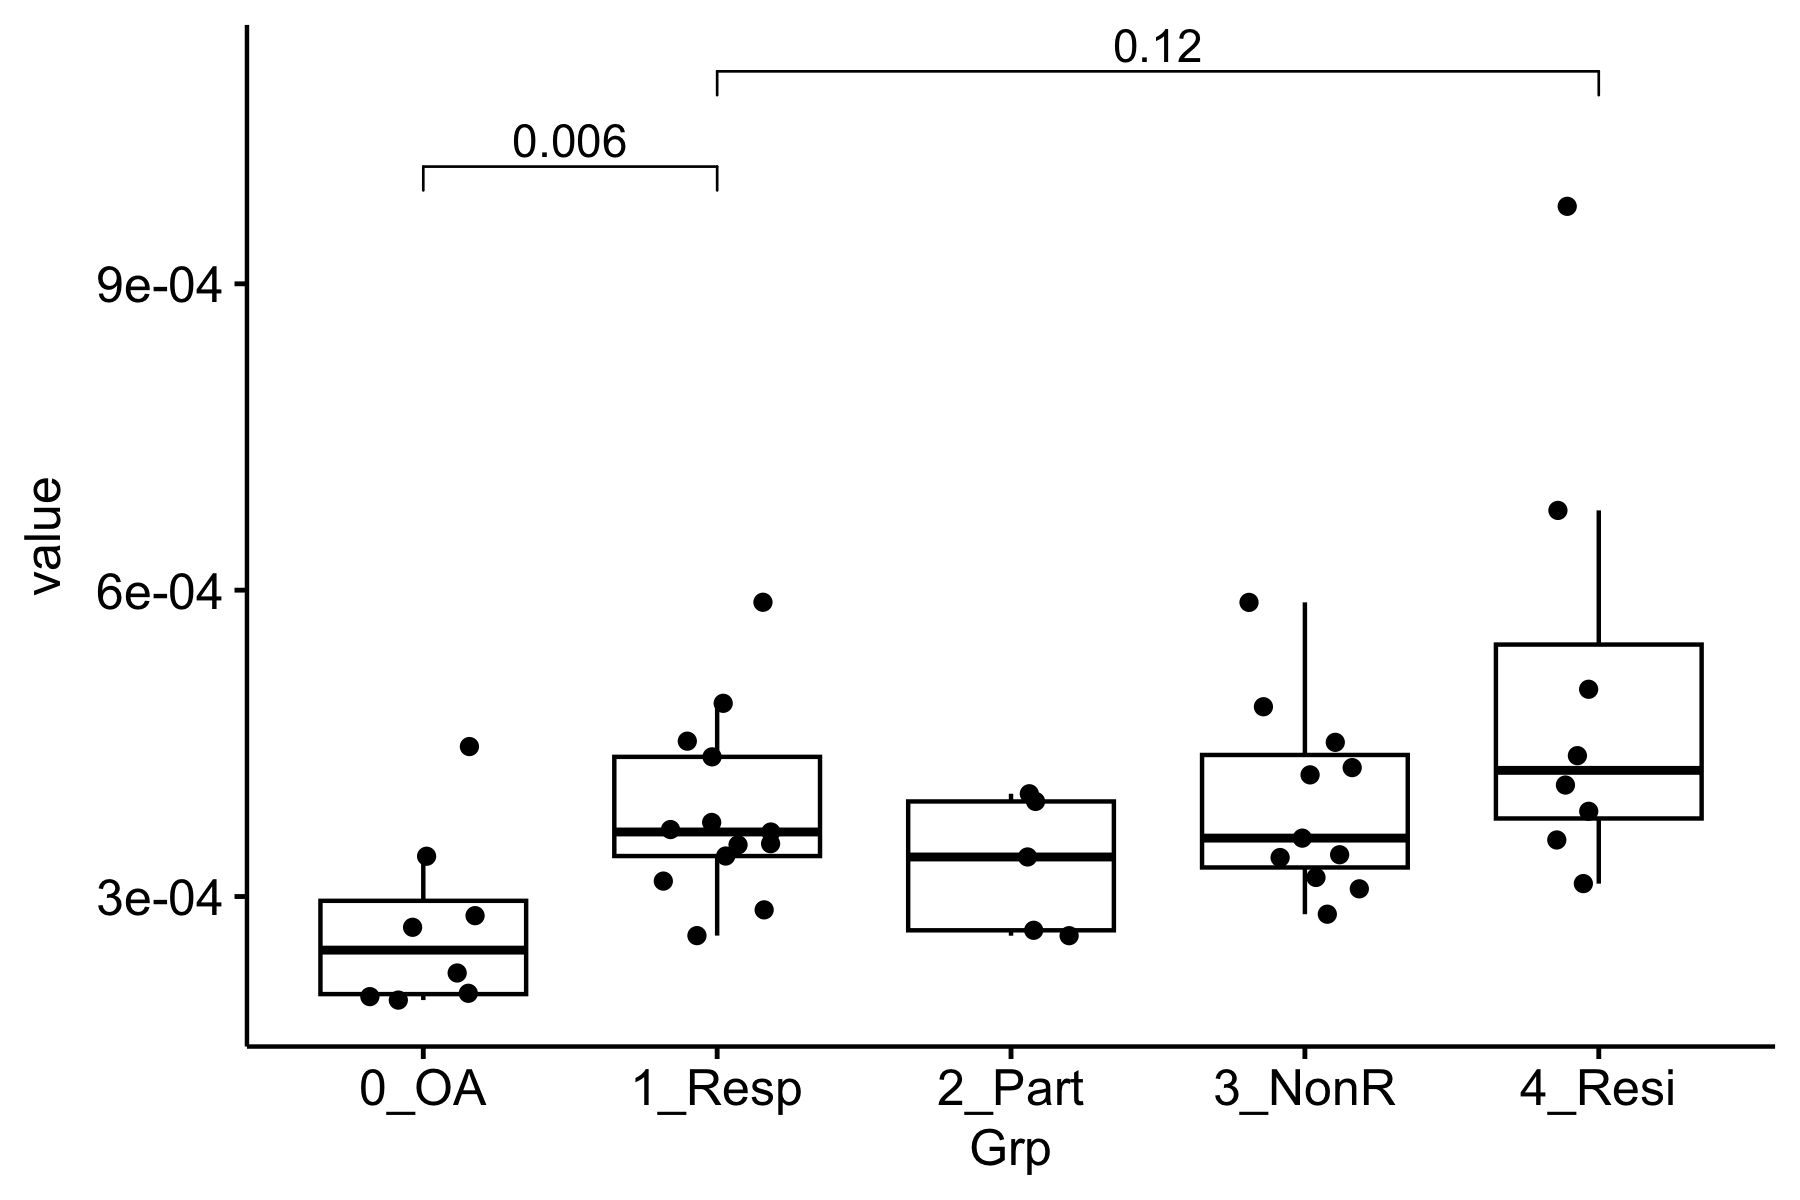

In [96]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)

my_comparisons <- list(c("0_OA", "1_Resp"), c("1_Resp", "4_Resi"))
library(ggpubr)
ggboxplot(df, x = "Grp", y = "value",
   add = "jitter") + 
stat_compare_means(comparisons = my_comparisons)

In [ ]:
saveRDS(gpop_fp, file = paste0('fp_', gpop, '.Rds'))
saveRDS(gpop_egc, file = paste0('egc_', gpop, '.Rds'))
saveRDS(genes_clean, file = paste0('genes_', gpop, '.Rds'))

In [97]:
gpop_fp_Mo <- log2(readRDS('fp_Mo.Rds'))
gpop_egc_Mo <- readRDS('egc_Mo.Rds')
genes_Mo <- readRDS('genes_Mo.Rds')

gpop_fp_Mf <- log2(readRDS('fp_Mf.Rds'))
gpop_egc_Mf <- readRDS('egc_Mf.Rds')
genes_Mf <- readRDS('genes_Mf.Rds')

gpop_fp_cDC2 <- log2(readRDS('fp_cDC2.Rds'))
gpop_egc_cDC2 <- readRDS('egc_cDC2.Rds')
genes_cDC2 <- readRDS('genes_cDC2.Rds')

In [98]:
genes <- Reduce(union, list(genes_Mo, genes_Mf, genes_cDC2))
genes <- setdiff(genes, c('CST7', 'LYZ', 'HLA-DRA', 'HLA-DPA1', 'HLA-DPB1', 'S100A9'))
genes <- c(genes, setdiff(c('TAP1', 'TAPBP', 'PSMB8', 'PSMB9', 'PSMB10'), genes))
sort(grep('^PSM', rownames(gpop_fp_Mo), v = T))

[1] "PSMA1"     "PSMA2"     "PSMA2P1"   "PSMA2P2"   "PSMA2P3"   "PSMA3"    
 [7] "PSMA3-AS1" "PSMA3P"    "PSMA4"     "PSMA5"     "PSMA6"     "PSMA6P1"  
[13] "PSMA6P2"   "PSMA6P4"   "PSMA7"     "PSMB1"     "PSMB10"    "PSMB2"    
[19] "PSMB3"     "PSMB3P2"   "PSMB4"     "PSMB5"     "PSMB6"     "PSMB7"    
[25] "PSMB8"     "PSMB8-AS1" "PSMB9"     "PSMC1"     "PSMC1P1"   "PSMC1P10" 
[31] "PSMC1P11"  "PSMC1P12"  "PSMC1P3"   "PSMC1P4"   "PSMC1P5"   "PSMC1P6"  
[37] "PSMC1P9"   "PSMC2"     "PSMC3"     "PSMC3IP"   "PSMC4"     "PSMC5"    
[43] "PSMC6"     "PSMD1"     "PSMD10"    "PSMD10P2"  "PSMD10P3"  "PSMD11"   
[49] "PSMD12"    "PSMD13"    "PSMD14"    "PSMD2"     "PSMD3"     "PSMD4"    
[55] "PSMD4P1"   "PSMD5"     "PSMD5-AS1" "PSMD6"     "PSMD6-AS1" "PSMD6-AS2"
[61] "PSMD7"     "PSMD8"     "PSMD8P1"   "PSMD9"     "PSME1"     "PSME2"    
[67] "PSME2P2"   "PSME2P6"   "PSME3"     "PSME4"     "PSMF1"     "PSMG1"    
[73] "PSMG2"     "PSMG3"     "PSMG3-AS1" "PSMG4"

[1] "ANKRD22"  "APOBEC3A" "ATF5"     "CXCL10"   "FAM26F"   "FGL2"    
 [7] "GBP1"     "GBP5"     "HLA-A"    "IFI6"     "IFITM1"   "IFITM3"  
[13] "IL4I1"    "ISG15"    "LAP3"     "MT2A"     "PSMB9"    "PSME2P2" 
[19] "RNF213"   "SERPING1" "SOD2"     "STAT1"    "TNFSF10"  "VAMP5"   
[25] "WARS"     "B2M"      "CXCL9"    "HLA-B"    "IFI27"    "PSME1"   
[31] "PSME2"    "SERPINA1" "XAF1"     "IFITM2"   "TAP1"     "TAPBP"   
[37] "PSMB8"    "PSMB10"

pdf 
  2

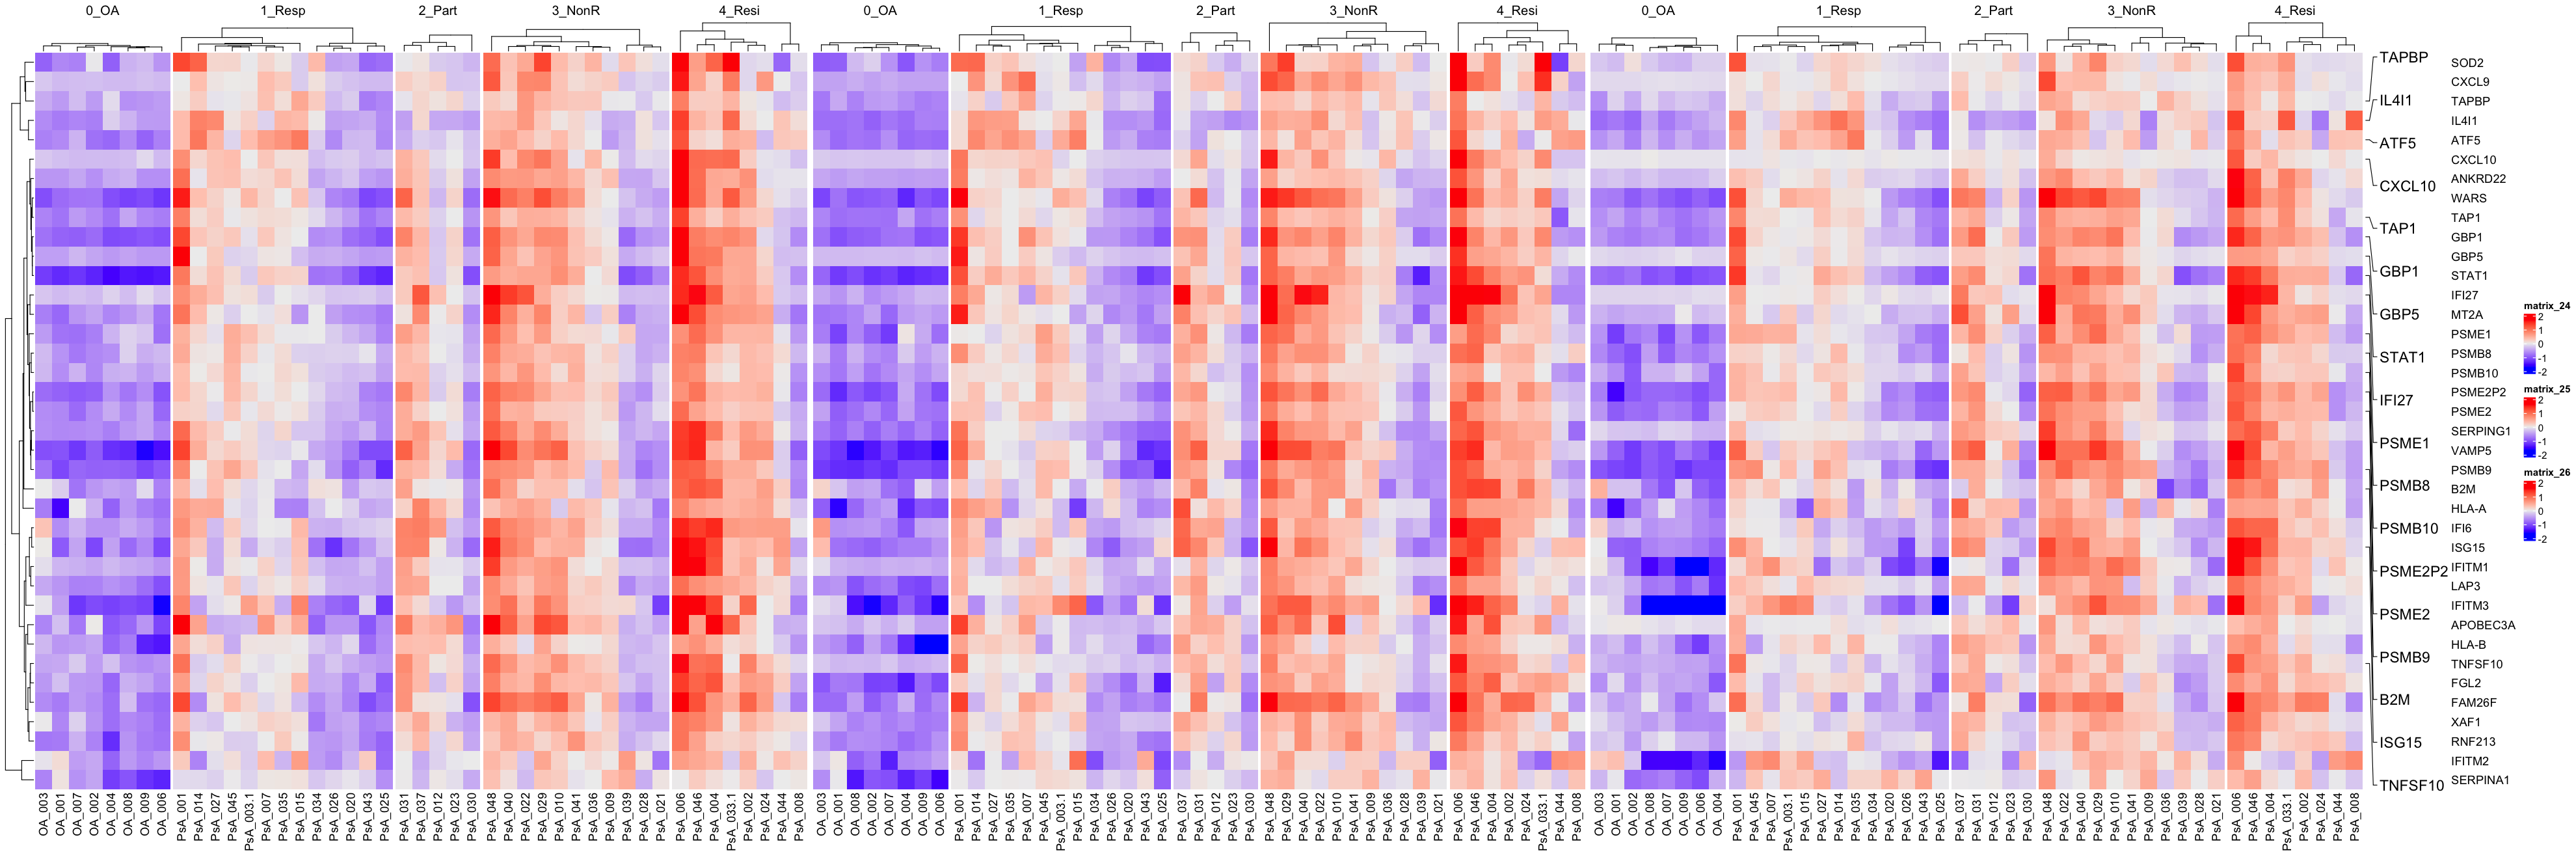

In [156]:
options(repr.plot.width = 36, repr.plot.height = 12, repr.plot.res = 110)

genes 
hi_genes <- c(3,4,7,8,13,14,17,18,22,23,26,29,30,31,35,36,37,38)
ra = rowAnnotation(foo = anno_mark(at = hi_genes, 
                                   labels = genes[hi_genes], 
                                   labels_gp = gpar(fontsize = 15), padding = 3))

H1 <- Heatmap(gpop_fp_Mo[genes, Resp_All], #bottom_annotation = ha,
              cluster_columns = T, 
              cluster_column_slices = F, 
              clustering_distance_row = 'spearman',
              column_split = rep(c("0_OA", "1_Resp", "2_Part", "3_NonR", "4_Resi"), 
                                 c(length(OA), length(Resp), length(Part), length(NonR), length(Resi))))
H2 <- Heatmap(gpop_fp_Mf[genes, Resp_All], #bottom_annotation = ha,
              cluster_columns = T, 
              cluster_column_slices = F, 
              clustering_distance_row = 'spearman',
              column_split = rep(c("0_OA", "1_Resp", "2_Part", "3_NonR", "4_Resi"), 
                                 c(length(OA), length(Resp), length(Part), length(NonR), length(Resi))))
H3 <- Heatmap(gpop_fp_cDC2[genes, Resp_All], #bottom_annotation = ha,
              right_annotation = ra,
              cluster_columns = T, 
              cluster_column_slices = F, 
              clustering_distance_row = 'spearman',
              column_split = rep(c("0_OA", "1_Resp", "2_Part", "3_NonR", "4_Resi"), 
                                 c(length(OA), length(Resp), length(Part), length(NonR), length(Resi))))
H <- H1 + H2 + H3

H
pdf('PsA_Fig4.pdf', width = 24, height = 8)
H
dev.off()

In [147]:
gene <- 'PSME2'

boxplot_egc <- function(gene, gpop_egc){
    df <- melt(gpop_egc[gene, Resp_All])
    df$Grp <- rep(c("0_OA", "1_Resp", "2_Part", "3_NonR", "4_Resi"), 
                           c(length(OA), length(Resp), length(Part), length(NonR), length(Resi)))
    my_comparisons <- list(c("0_OA", "1_Resp"), c("1_Resp", "4_Resi"))
    box <- ggboxplot(df, x = "Grp", y = "value", 
                     add = "jitter") + 
    ylim(0, 6e-4) +
    stat_compare_means(comparisons = my_comparisons)
    box
}

In [148]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)

A <- boxplot_egc(gene, gpop_egc_Mo)
B <- boxplot_egc(gene, gpop_egc_Mf)
C <- boxplot_egc(gene, gpop_egc_cDC2)

pdf 
  2

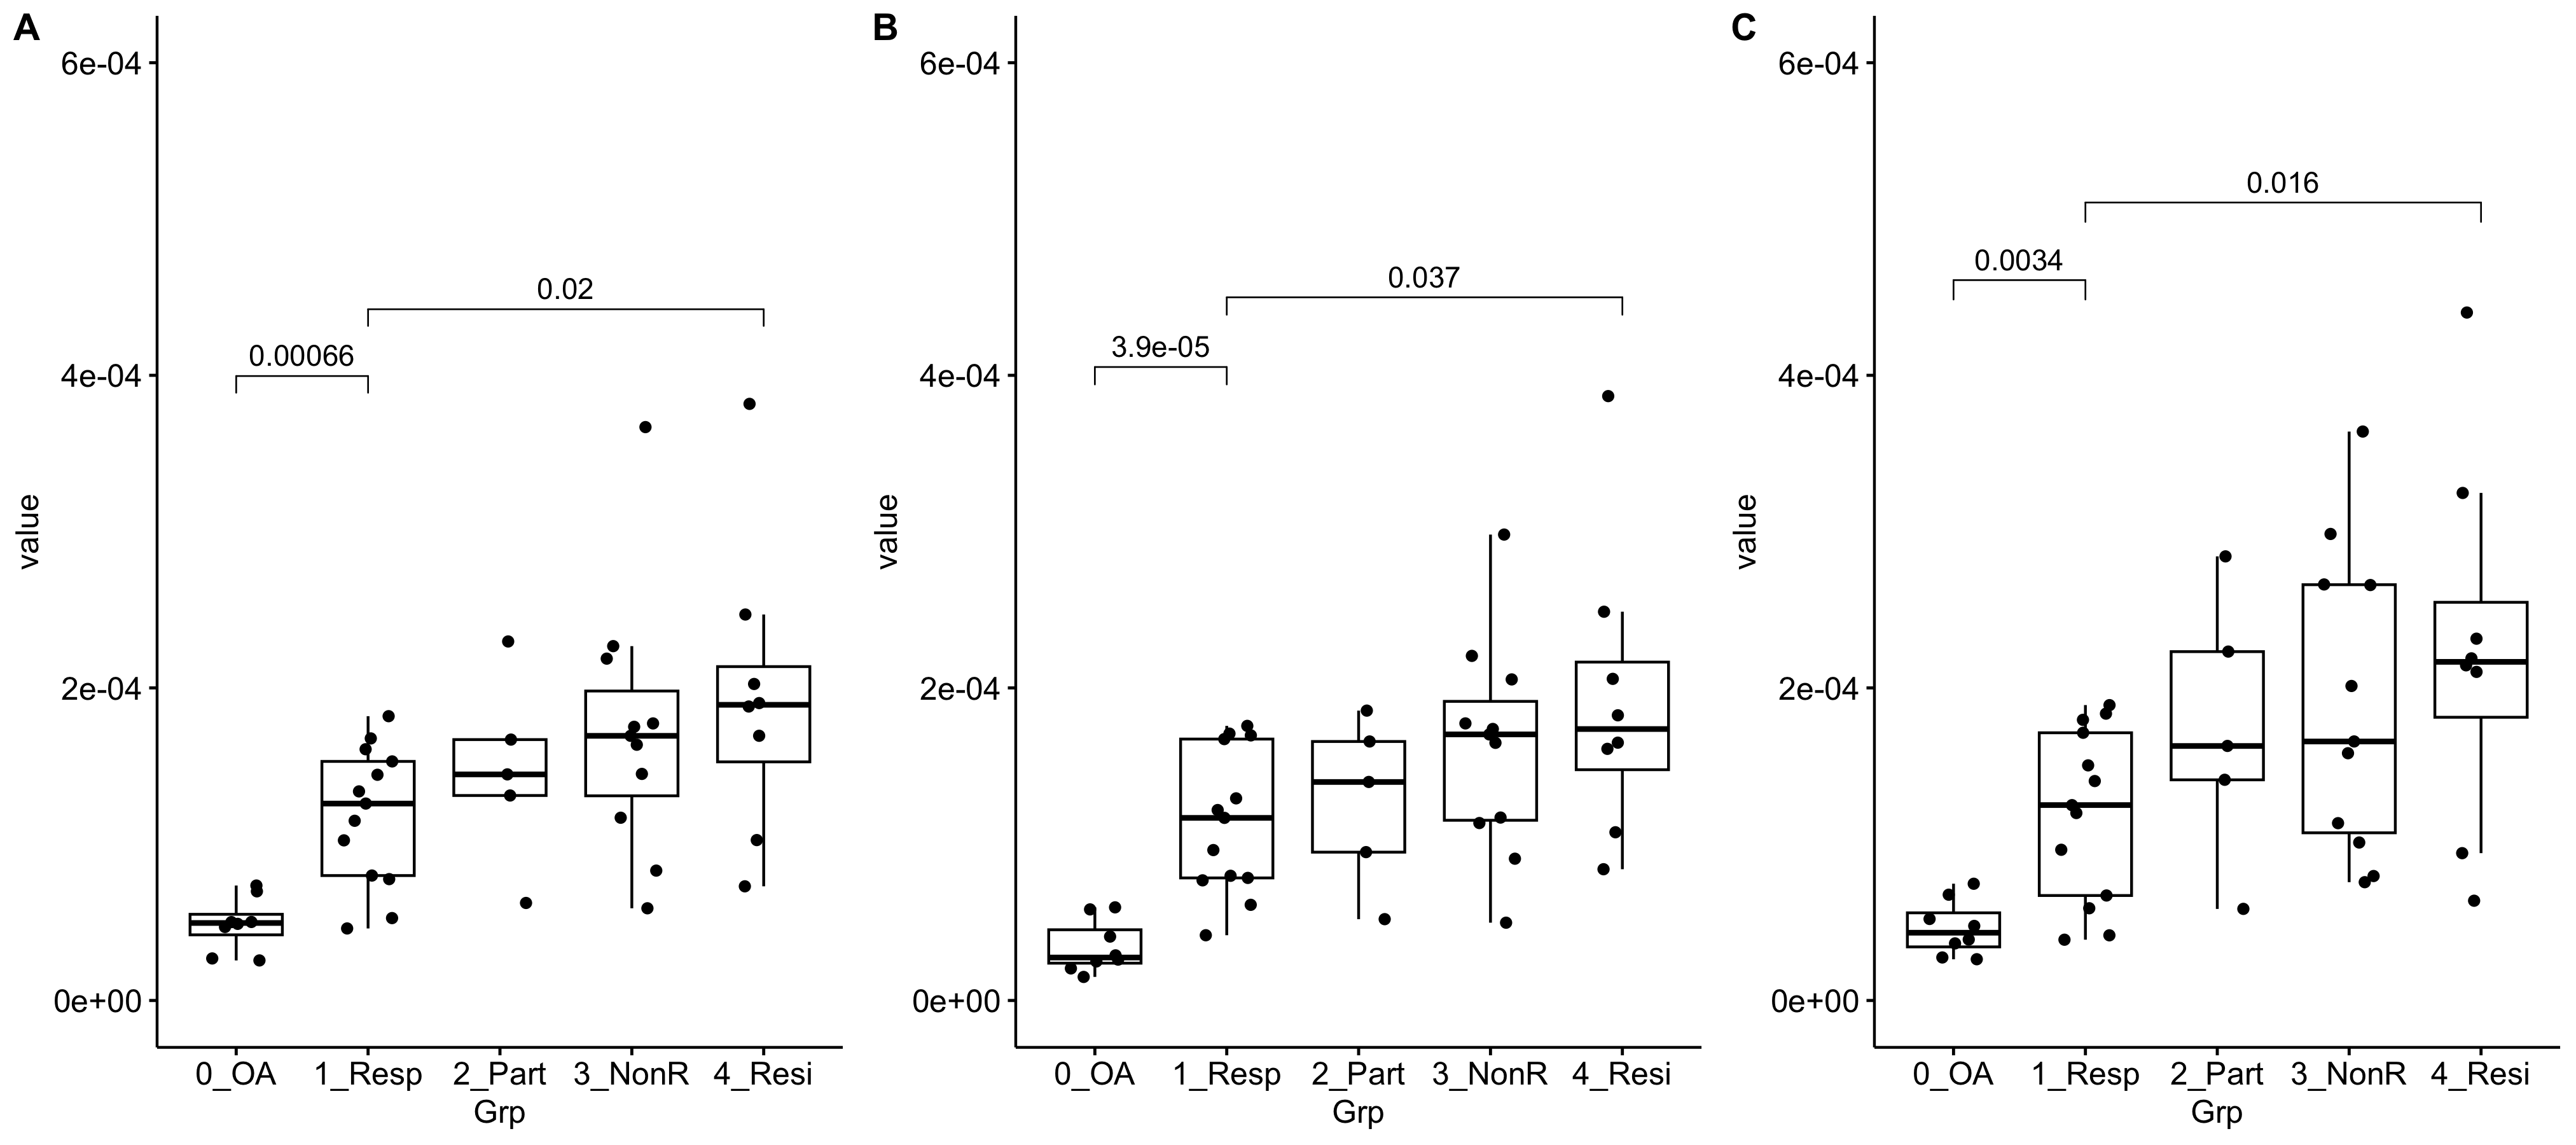

In [149]:
options(repr.plot.width = 13.5, repr.plot.height = 6, repr.plot.res = 300)

BOX <- ggarrange(A, B, C, 
                 labels = c("A", "B", "C"),
                 nrow = 1)

BOX
pdf(paste0('PsA_Fig4_', gene, '.pdf'), width = 13.5, height = 6)
BOX
dev.off()

In [29]:
dim(cells_Imm)
head(cells_Imm)

[1] 122373     16

,amp_batch_id,mcID,cID,seq_batch_id,Populations,pop,Seq.Batch.ID,Batch.Set.ID,Patient_Name,Diagnosis,Gating,Tissue,Sample,PID,Note,batch_set_id
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
W3876380,AB10032,58,W3876380,SB202,Mo_Blood,Mo_Blood,SB202,Biomek_A1_FMF blood Healthy Tali CD45_2,Blood_Tali,Control,CD45,Blood,-,Control_Tali,-,Biomek_A1_FMF blood Healthy Tali CD45_2
W3876226,AB10032,255,W3876226,SB202,NK,NK,SB202,Biomek_A1_FMF blood Healthy Tali CD45_2,Blood_Tali,Control,CD45,Blood,-,Control_Tali,-,Biomek_A1_FMF blood Healthy Tali CD45_2
W3876251,AB10032,254,W3876251,SB202,NK,NK,SB202,Biomek_A1_FMF blood Healthy Tali CD45_2,Blood_Tali,Control,CD45,Blood,-,Control_Tali,-,Biomek_A1_FMF blood Healthy Tali CD45_2
W3876073,AB10032,336,W3876073,SB202,cDC2,cDC2,SB202,Biomek_A1_FMF blood Healthy Tali CD45_2,Blood_Tali,Control,CD45,Blood,-,Control_Tali,-,Biomek_A1_FMF blood Healthy Tali CD45_2
W3876429,AB10032,517,W3876429,SB202,B,B,SB202,Biomek_A1_FMF blood Healthy Tali CD45_2,Blood_Tali,Control,CD45,Blood,-,Control_Tali,-,Biomek_A1_FMF blood Healthy Tali CD45_2
W3876129,AB10032,511,W3876129,SB202,B,B,SB202,Biomek_A1_FMF blood Healthy Tali CD45_2,Blood_Tali,Control,CD45,Blood,-,Control_Tali,-,Biomek_A1_FMF blood Healthy Tali CD45_2


character(0)

character(0)

pdf 
  2

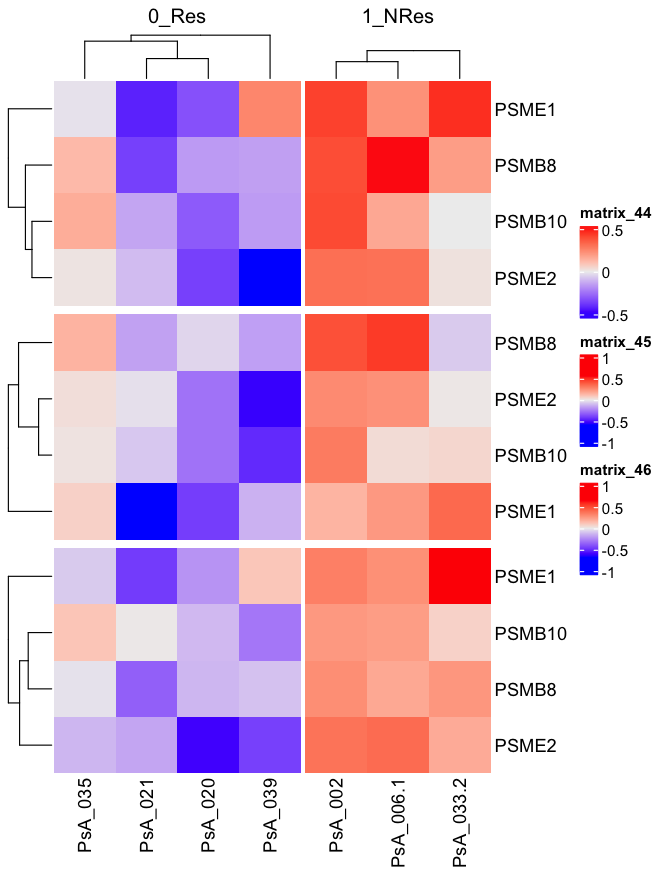

In [172]:
genes_Now <- c('PSME1', 'PSME2', 'PSMB8', 'PSMB10')
Resp_Now <- c('PsA_021', 'PsA_035', 'PsA_039', 'PsA_020', 'PsA_002', 'PsA_006.1', 'PsA_033.2')
setdiff(genes_Now, rownames(gpop_fp_Mo))
setdiff(Resp_Now, colnames(gpop_fp_Mo))

H1 <- Heatmap(gpop_fp_Mo[genes_Now, Resp_Now],
              cluster_column_slices = F, 
              column_split = rep(c("0_Res", "1_NRes"), c(4, 3)))
H2 <- Heatmap(gpop_fp_Mf[genes_Now, Resp_Now],
              cluster_column_slices = F, 
              column_split = rep(c("0_Res", "1_NRes"), c(4, 3)))
H3 <- Heatmap(gpop_fp_cDC2[genes_Now, Resp_Now],
              cluster_column_slices = F, 
              column_split = rep(c("0_Res", "1_NRes"), c(4, 3)))
H <- H1 %v% H2 %v% H3

options(repr.plot.width = 6, repr.plot.height = 8, repr.plot.res = 110)
H
pdf('PsA_Fig4D.pdf', width = 6, height = 8)
H
dev.off()